In [1]:
import pandas as pd
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
file_path = 'weatherAUS.csv'
Aus_weather = pd.read_csv(file_path)
Aus_weather['Date'] = pd.to_datetime(Aus_weather['Date'])
def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
Aus_weather['Season'] = Aus_weather['Date'].apply(get_season)
df_spring = Aus_weather[Aus_weather['Season'] == 'Spring']
df_summer = Aus_weather[Aus_weather['Season'] == 'Summer']
df_autumn = Aus_weather[Aus_weather['Season'] == 'Autumn']
df_winter = Aus_weather[Aus_weather['Season'] == 'Winter']

In [3]:
len(df_spring)

38264

In [4]:
def preprocess_weather_data(df):
    # Impute missing values for numerical columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    imputer_num = SimpleImputer(strategy='median')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])

    # Drop certain categorical columns
    df = df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Date', 'Season'], axis=1)

    # Impute missing values for remaining categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

    # Encode categorical variables
    label_encoders = {}
    for column in cat_cols:
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column].astype(str))
        label_encoders[column] = label_encoder

    return df, label_encoders

In [5]:
# def undersampling(data, target, i):
#     data, _ = preprocess_weather_data(data)
#     X = data.drop(target, axis=1)
#     y = data[target]
#     tl = TomekLinks()
#     enn = EditedNearestNeighbours()
#     X_resampled, y_resampled = enn.fit_resample(X, y)
#     resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
#     resampled_data[target] = y_resampled
#     resampled_data.to_csv(f'{i}_ENN.csv', index=False)

In [6]:
# seasonable_datas = [df_spring, df_summer, df_autumn, df_winter]
# for i in range(4):
#     undersampling(seasonable_datas[i], 'RainTomorrow', i)

In [7]:
spring_df = preprocess_weather_data(df_spring)[0]
summer_df = preprocess_weather_data(df_summer)[0]
autumn_df = preprocess_weather_data(df_autumn)[0]
winter_df = preprocess_weather_data(df_winter)[0]
print(spring_df[spring_df['RainTomorrow']==1].shape)
print(spring_df[spring_df['RainTomorrow']==0].shape)

/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_8534/271597954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = imputer_num.fit_transform(df[num_cols])
/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_8534/271597954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = imputer_num.fit_transform(df[num_cols])
/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_8534/271597954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

(8185, 18)
(30079, 18)


/var/folders/3j/9b_qh0z13pv__zzfxvd58x_r0000gn/T/ipykernel_8534/271597954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = imputer_num.fit_transform(df[num_cols])


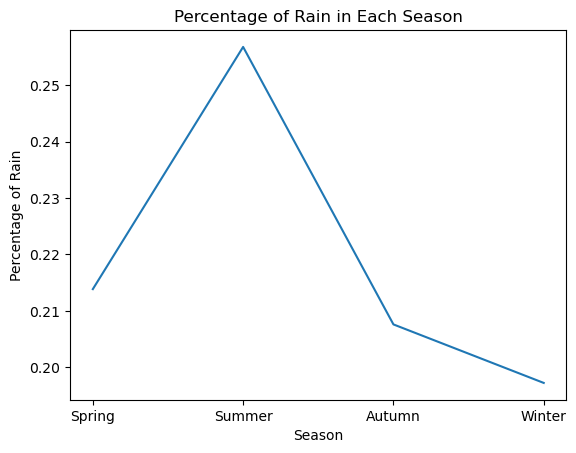

In [8]:
#draw the graph of the percentage of rain in each season
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
rainy_days = [spring_df[spring_df['RainToday']==1].shape[0], summer_df[summer_df['RainToday']==1].shape[0], autumn_df[autumn_df['RainToday']==1].shape[0], winter_df[winter_df['RainToday']==1].shape[0]]
total_days = [spring_df.shape[0], summer_df.shape[0], autumn_df.shape[0], winter_df.shape[0]]
percentage = [rainy_days[i]/total_days[i] for i in range(4)]
plt.plot(seasons, percentage)
plt.xlabel('Season')
plt.ylabel('Percentage of Rain')
plt.title('Percentage of Rain in Each Season')
plt.show()


In [9]:
X = spring_df.drop(['RainTomorrow'], axis=1)
y = spring_df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# smote=SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
#grid search on balanced random forest
param_grid = {'n_estimators': [100,300], 'max_depth': [None,5,6], 'min_samples_leaf': [2], 'class_weight': ['balanced',None]}
BRF = BalancedRandomForestClassifier(random_state=42)
grid_search = GridSearchCV(BRF, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
brf = RandomForestClassifier(**grid_search.best_params_,random_state=42)
# model.fit(X_train_pca, y_train)
# y_pred_pca = model.predict(X_test_pca)
brf.fit(X_train_scaled, y_train)
y_pred = brf.predict(X_test_scaled)
# accuracy_pca = accuracy_score(y_test, y_pred_pca)
# classification_rep_pca = classification_report(y_test, y_pred_pca)
accuracy_pca = accuracy_score(y_test, y_pred)
classification_rep_pca = classification_report(y_test, y_pred)
print(classification_rep_pca)


/Users/bobby/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/bobby/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/bobby/opt/anaconda3/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adop

{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 300}
0.7957596645442713
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5998
           1       0.77      0.51      0.61      1655

    accuracy                           0.86      7653
   macro avg       0.82      0.73      0.76      7653
weighted avg       0.85      0.86      0.85      7653



In [13]:
weights = np.where(y_train == 0, 1, 8)

In [14]:
#use grid search to find the best parameters
param_grid = {'n_estimators': [100,300], 'max_depth': [None,5,6], 'min_samples_leaf': [2]}
RF = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train, sample_weight=weights)
print(grid_search.best_params_)
print(grid_search.best_score_)
RF = RandomForestClassifier(**grid_search.best_params_,random_state=42)
# model.fit(X_train_pca, y_train)
# y_pred_pca = model.predict(X_test_pca)
RF.fit(X_train_scaled, y_train, sample_weight=weights)
y_pred = RF.predict(X_test_scaled)
# accuracy_pca = accuracy_score(y_test, y_pred_pca)
# classification_rep_pca = classification_report(y_test, y_pred_pca)
accuracy_pca = accuracy_score(y_test, y_pred)
classification_rep_pca = classification_report(y_test, y_pred)
print(classification_rep_pca)

{'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 300}
0.8509359875786068
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5998
           1       0.72      0.55      0.62      1655

    accuracy                           0.86      7653
   macro avg       0.80      0.75      0.77      7653
weighted avg       0.85      0.86      0.85      7653



In [15]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Assuming X_train_scaled, y_train, X_test_scaled, y_test, and X are already defined

# Define the parameter grid
param_grid = {
    'n_estimators': [100,300,500],
    'max_depth': [None,5,6],
    'learning_rate': [0.05,0.1]
}

# Create a XGBClassifier instance
xgbtest = xgb.XGBClassifier(objective='binary:logistic')

# Set up GridSearchCV
grid_search = GridSearchCV(xgbtest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train, sample_weight=weights)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Create a new model with the best parameters
XGB = xgb.XGBClassifier(objective='binary:logistic', **grid_search.best_params_)
XGB.fit(X_train_scaled, y_train, sample_weight=weights)

# Make predictions
y_pred = XGB.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns, 
    'importance': XGB.feature_importances_
}).sort_values('importance', ascending=False)

# Print the top 3 features
print(feature_importance.head(3))


Best Parameters: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500}
Best Score: 0.8051352212668712
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5998
           1       0.53      0.80      0.64      1655

    accuracy                           0.80      7653
   macro avg       0.73      0.80      0.75      7653
weighted avg       0.85      0.80      0.82      7653

          feature  importance
11    Humidity3pm    0.251254
5   WindGustSpeed    0.105699
13    Pressure3pm    0.066039


In [16]:
#logistic regression
from sklearn.linear_model import LogisticRegression
#use grid search to find the best parameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train, sample_weight=weights)
print(grid.best_params_)
print(grid.best_score_)
logreg = LogisticRegression(**grid.best_params_)
logreg.fit(X_train_scaled, y_train, sample_weight=weights)
y_pred = logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep_pca = classification_report(y_test, y_pred)
print(classification_rep_pca)

{'C': 10}
0.6501910603935878
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      5998
           1       0.38      0.89      0.53      1655

    accuracy                           0.66      7653
   macro avg       0.66      0.74      0.63      7653
weighted avg       0.83      0.66      0.69      7653



In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

model = NeuralNet()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # Adjusting the output shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()  # Adjusting the output shape
        y_pred.extend(outputs.round().numpy())

# Convert predictions to a format suitable for classification report
y_pred = np.array(y_pred).flatten()

# Compute classification report
classification_rep = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5998
           1       0.78      0.47      0.59      1655

    accuracy                           0.86      7653
   macro avg       0.83      0.72      0.75      7653
weighted avg       0.85      0.86      0.84      7653



NN: ROC AUC=0.719
RF: ROC AUC=0.883
XGB: ROC AUC=0.883
Logistic Regression: ROC AUC=0.862
Balanced Random Forest: ROC AUC=0.883


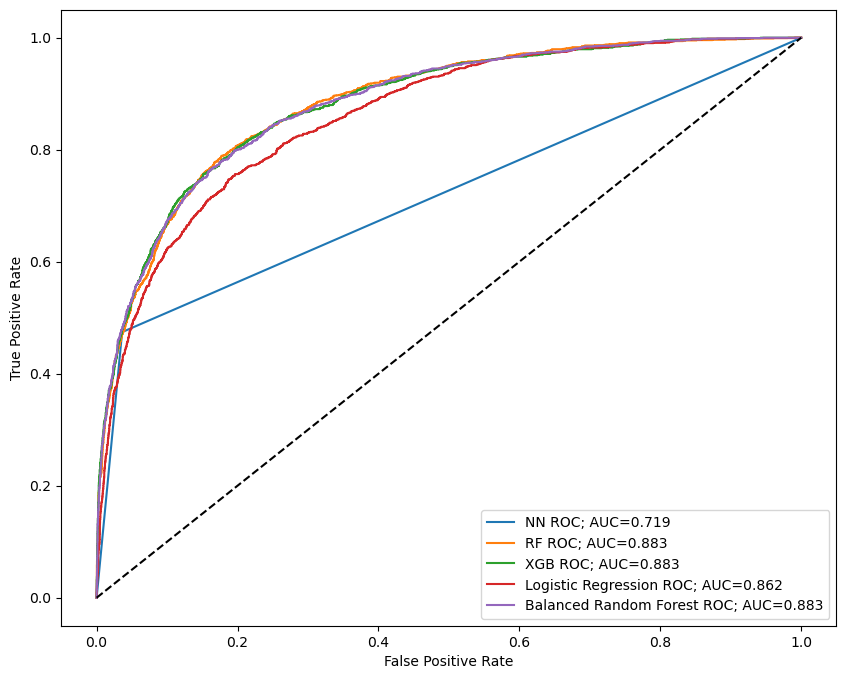

In [18]:
#draw the auc and roc graph of the models above
# Compute predicted probabilities: y_pred_prob
NNy_pred_prob = y_pred
rfy_pred_prob = RF.predict_proba(X_test_scaled)[:,1]
xgby_pred_prob = XGB.predict_proba(X_test_scaled)[:,1]
logy_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]
brfy_pred_prob = brf.predict_proba(X_test_scaled)[:,1]
plt.figure(figsize=(10,8))
#generate the auc score
NN_auc = roc_auc_score(y_test, NNy_pred_prob)
rf_auc = roc_auc_score(y_test, rfy_pred_prob)
xgb_auc = roc_auc_score(y_test, xgby_pred_prob)
log_auc = roc_auc_score(y_test, logy_pred_prob)
brf_auc = roc_auc_score(y_test, brfy_pred_prob)
print('NN: ROC AUC=%.3f' % (NN_auc))
print('RF: ROC AUC=%.3f' % (rf_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
print('Logistic Regression: ROC AUC=%.3f' % (log_auc))
print('Balanced Random Forest: ROC AUC=%.3f' % (brf_auc))
# Generate ROC curve values: fpr, tpr, thresholds
NNfpr, NNtpr, NNthresholds = roc_curve(y_test, NNy_pred_prob)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rfy_pred_prob)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgby_pred_prob)
log_fpr, log_tpr, log_thresholds = roc_curve(y_test, logy_pred_prob)
brf_fpr, brf_tpr, brf_thresholds = roc_curve(y_test, brfy_pred_prob)
# Plot ROC curve
plt.plot(NNfpr, NNtpr, label='NN ROC; AUC=%.3f' % (NN_auc))
plt.plot(rf_fpr, rf_tpr, label='RF ROC; AUC=%.3f' % (rf_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGB ROC; AUC=%.3f' % (xgb_auc))
plt.plot(log_fpr, log_tpr, label='Logistic Regression ROC; AUC=%.3f' % (log_auc))
plt.plot(brf_fpr, brf_tpr, label='Balanced Random Forest ROC; AUC=%.3f' % (brf_auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Label axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show the plot
plt.legend()
plt.show()






In [20]:
#draw the confusion matrix of the models above
# Generate confusion matrix
NN_matrix = confusion_matrix(y_test, y_pred)
rf_matrix = confusion_matrix(y_test, RF.predict(X_test_scaled))
xgb_matrix = confusion_matrix(y_test, XGB.predict(X_test_scaled))
log_matrix = confusion_matrix(y_test, logreg.predict(X_test_scaled))
brf_matrix = confusion_matrix(y_test, brf.predict(X_test_scaled))
# Print the confusion matrix
print(NN_matrix)
print(rf_matrix)
print(xgb_matrix)
print(log_matrix)
print(brf_matrix)

[[5781  217]
 [ 870  785]]
[[5648  350]
 [ 747  908]]
[[4835 1163]
 [ 338 1317]]
[[3542 2456]
 [ 174 1481]]
[[5749  249]
 [ 819  836]]


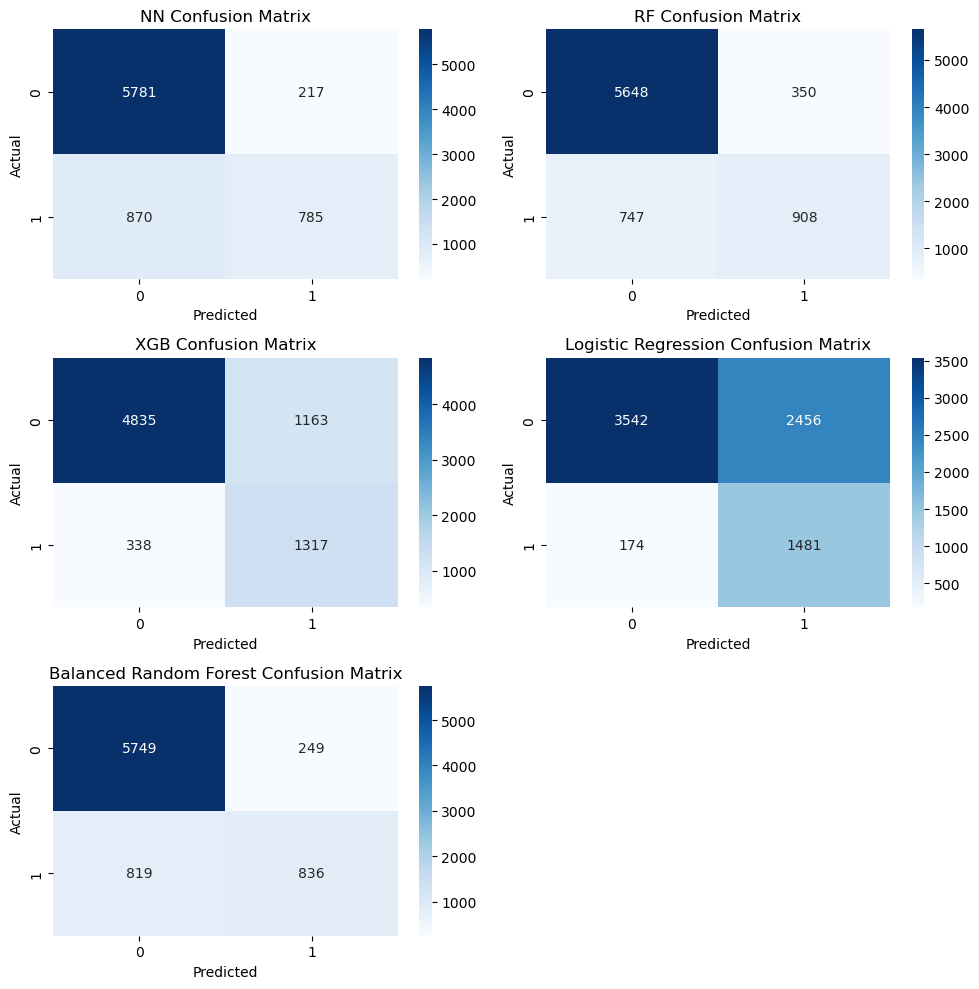

In [21]:
#plot the confusion matrix
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
sns.heatmap(NN_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('NN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,2)
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,3)
sns.heatmap(xgb_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('XGB Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,4)
sns.heatmap(log_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.subplot(3,2,5)
sns.heatmap(brf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Balanced Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [ ]:
#perform grid search to find the best parameters for the random forest model
# Create the parameter grid based on the results of random search
#
param_grid = {
    'max_depth': [None],
    'min_samples_leaf': [4,6,8],
    'min_samples_split': [2,4,6],
    'n_estimators': [100,200,300]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Inte

In [ ]:
#perform grid search for the xgboost model
# Create the parameter grid based on the results of random search
#
import xgboost as xgb
param_grid = {
    'max_depth': [5,7,9],
    'n_estimators': [100,200,300]
}
# Create a based model
xgb = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=   2.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=   2.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   2.5s
[CV] END ......................max_depth=7, n_estimators=100; total time=   3.1s
[CV] END ......................max_depth=7, n_estimators=100; total time=   3.3s
[CV] END ......................max_depth=7, n_estimators=100; total time=   3.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   4.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   4.5s
[CV] END ......................max_depth=5, n_estimators=200; total time=   4.6s
[CV] END ......................max_depth=5, n_estimators=300; total time=   6.4s
[CV] END ......................max_depth=5, n_estimators=300; total time=   6.4s
[CV] END ......................max_depth=5, n_est

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2, scoring='recall')
grid_search_rf.fit(X_train_preprocessed, y_train)


In [ ]:

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
param_grid_xgb = {
    'max_depth': [3, 6, 10],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight]
}

xgb_model = xgb.XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2, scoring='recall')
grid_search_xgb.fit(X_train_preprocessed, y_train)


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 500],
    'class_weight': ['balanced']
}

log_reg = LogisticRegression(random_state=42)
grid_search_logreg = GridSearchCV(estimator=log_reg, param_grid=param_grid_logreg, cv=3, n_jobs=-1, verbose=2, scoring='recall')
grid_search_logreg.fit(X_train_preprocessed, y_train)
